# Détection du Cancer du Sein - Projet CRISP-DM (Version Éducative)

## 📚 Objectif de ce Notebook

Ce notebook est une version éducative complètement commentée en français. Il explique **ligne par ligne** et **paramètre par paramètre** toutes les décisions prises lors de l'implémentation de 6 algorithmes de machine learning pour la détection du cancer du sein.

**Structure du projet :**
- Suit la méthodologie CRISP-DM (Cross-Industry Standard Process for Data Mining)
- Implémente 6 algorithmes différents pour comparaison
- Explique chaque choix architectural et hyperparamètre

---

## 1. Compréhension Métier (Business Understanding)

### Objectif
Prédire si une tumeur du sein est **maligne** (cancéreuse) ou **bénigne** (non-cancéreuse) en utilisant des algorithmes d'apprentissage automatique.

### Contexte
- **Problème de classification binaire** : 2 classes (Bénin/Malin)
- **Données médicales** : Caractéristiques mesurées sur des cellules de tumeurs
- **Application critique** : Aide au diagnostic médical

---

## 2. Compréhension des Données (Data Understanding)

In [3]:
# ============================================================================
# IMPORTATION DES BIBLIOTHÈQUES
# ============================================================================
# Cette cellule importe toutes les bibliothèques nécessaires au projet

# --- Bibliothèques de base pour la manipulation de données ---
import pandas as pd  # Manipulation de DataFrames (tableaux de données)
import numpy as np   # Calculs numériques et opérations sur tableaux
import matplotlib.pyplot as plt  # Visualisation de graphiques
import seaborn as sns  # Visualisation statistique avancée (basé sur matplotlib)

# --- Scikit-learn : Machine Learning et préprocessing ---
from sklearn.model_selection import train_test_split  # Division train/test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Standarisation et Normalisation
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression  # Régression linéaire avec SGD et Logistic Regression
from sklearn.svm import SVC  # Support Vector Machine (SVM)
from sklearn.neural_network import MLPClassifier  # Multi-Layer Perceptron (réseau de neurones)
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN)

# --- Métriques d'évaluation ---
from sklearn.metrics import (
    confusion_matrix,    # Matrice de confusion (TP, TN, FP, FN)
    roc_auc_score,       # Aire sous la courbe ROC (mesure de performance)
    roc_curve,           # Courbe ROC (True Positive Rate vs False Positive Rate)
    accuracy_score,      # Précision (pourcentage de prédictions correctes)
    recall_score,        # Rappel (Sensibilité - capacité à détecter les vrais positifs)
    precision_score,     # Précision (proportion de vrais positifs parmi les prédictions positives)
    f1_score,            # Score F1 (moyenne harmonique de précision et rappel)
    mean_squared_error   # Erreur quadratique moyenne (pour régression)
)

# --- TensorFlow/Keras : Deep Learning (optionnel) ---
# On utilise try/except car TensorFlow n'est pas toujours installé
try:
    from tensorflow.keras.models import Sequential  # Modèle séquentiel (couches empilées)
    from tensorflow.keras.layers import GRU, Dense, Dropout, Input  # Types de couches
    # GRU: Gated Recurrent Unit (réseau récurrent)
    # Dense: Couche fully-connected (tous les neurones connectés)
    # Dropout: Régularisation (désactive aléatoirement des neurones)
    # Input: Couche d'entrée explicite
    from tensorflow.keras.callbacks import EarlyStopping  # Arrêt anticipé pour éviter le surapprentissage
    from tensorflow.keras.optimizers import Adam  # Optimiseur Adam (adaptatif)
    TENSORFLOW_AVAILABLE = True  # Flag indiquant que TensorFlow est disponible
except ImportError:
    # Si TensorFlow n'est pas installé, on continue sans (pour les modèles basiques)
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow non disponible - Le modèle GRU-SVM ne sera pas entraîné")

# Configuration du style des graphiques
sns.set_style("whitegrid")  # Fond blanc avec grille (style propre et lisible)

In [4]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================
# Lecture du fichier CSV contenant les données sur les tumeurs du sein

df = pd.read_csv('data.csv')  # Charge le fichier CSV dans un DataFrame pandas
# Le DataFrame 'df' contient toutes les observations (lignes) et caractéristiques (colonnes)

df.head()  # Affiche les 5 premières lignes pour avoir un aperçu des données
# Utile pour vérifier que les données sont chargées correctement

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
# ============================================================================
# EXPLORATION INITIALE DES DONNÉES
# ============================================================================
# Cette cellule donne un aperçu général de la structure du dataset

# df.shape retourne un tuple (nombre_lignes, nombre_colonnes)
print(f"Dataset shape: {df.shape}")  # Exemple: (569, 33) = 569 échantillons, 33 colonnes
print(f"Features: {df.shape[1] - 1}")  # Nombre de features (colonnes - 1 car on exclut la colonne 'diagnosis')
print(f"Samples: {df.shape[0]}")  # Nombre d'échantillons (patients/tumeurs)

# df.info() affiche des informations détaillées sur chaque colonne :
# - Nom de la colonne
# - Nombre de valeurs non-nulles
# - Type de données (int64, float64, object, etc.)
df.info()
# Utile pour détecter les valeurs manquantes et comprendre les types de données

Dataset shape: (569, 33)
Features: 32
Samples: 569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 

### 📊 Aperçu du Dataset

**Informations clés :**
- **569 échantillons** : Nombre de tumeurs analysées
- **30 features** : Caractéristiques mesurées (rayon, texture, périmètre, etc.)
- **1 variable cible** : `diagnosis` (B = Bénin, M = Malin)
- **3 colonnes supplémentaires** : `id` (identifiant), `Unnamed: 32` (vide), et `diagnosis`

**Structure des features :**
Les 30 features sont dérivées de 10 mesures de base :
- **Mean (moyenne)** : x0-x9 (10 features)
- **Standard Error (erreur standard)** : x10-x19 (10 features)  
- **Worst (pire valeur)** : x20-x29 (10 features)

In [6]:
# ============================================================================
# VÉRIFICATION DES VALEURS MANQUANTES
# ============================================================================
# Les valeurs manquantes peuvent affecter les performances des modèles
# Il est crucial de les identifier avant le preprocessing

# df.isnull() retourne un DataFrame booléen (True si valeur manquante, False sinon)
# .sum().sum() additionne toutes les valeurs True dans tout le DataFrame
missing_count = df.isnull().sum().sum()  # Nombre total de valeurs manquantes
print(f"Total missing values: {missing_count}")



Total missing values: 569


In [7]:
# ============================================================================
# STATISTIQUES DESCRIPTIVES
# ============================================================================
# .describe() fournit un résumé statistique de toutes les colonnes numériques

df.describe()
# Retourne pour chaque colonne numérique :
# - count : Nombre de valeurs non-nulles
# - mean : Moyenne
# - std : Écart-type (dispersion des données)
# - min : Valeur minimale
# - 25% : Premier quartile (25% des valeurs sont en dessous)
# - 50% : Médiane (50% des valeurs sont en dessous)
# - 75% : Troisième quartile (75% des valeurs sont en dessous)
# - max : Valeur maximale
# Utile pour détecter les valeurs aberrantes et comprendre la distribution des données

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 📐 Structure des Features

Le dataset contient **30 features** dérivées de **10 mesures de base** :
- **Mean (moyenne)** : x0-x9 (10 features) - Valeur moyenne de chaque caractéristique
- **Standard Error (erreur standard)** : x10-x19 (10 features) - Variabilité de la mesure
- **Worst (pire valeur)** : x20-x29 (10 features) - Valeur la plus problématique observée

**Exemple :** Pour le rayon des cellules :
- `radius_mean` : Rayon moyen
- `radius_se` : Erreur standard du rayon
- `radius_worst` : Plus grand rayon observé

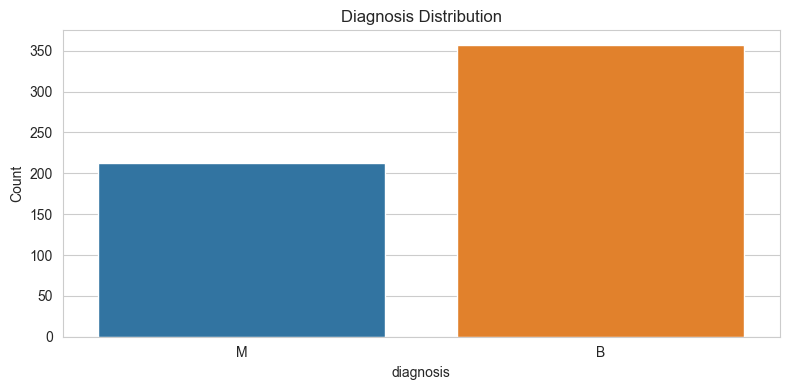

Class distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
Imbalance ratio: 1.68:1 (Benign:Malignant)


In [8]:
# ============================================================================
# DISTRIBUTION DES CLASSES (BÉNIN vs MALIN)
# ============================================================================
# Il est important de vérifier l'équilibre des classes avant l'entraînement

# Création d'une figure pour la visualisation
plt.figure(figsize=(8, 4))  # Taille : 8 pouces de large, 4 pouces de haut

# Comptage du nombre d'occurrences de chaque classe
diagnosis_counts = df['diagnosis'].value_counts()
# Retourne : B = 357, M = 212 (par exemple)

# Création d'un graphique en barres (countplot)
sns.countplot(
    x='diagnosis',  # Variable sur l'axe X
    data=df,  # DataFrame source
    hue='diagnosis',  # Couleur différente pour chaque classe
    legend=False  # Pas de légende (redondant avec les labels)
)
plt.title('Diagnosis Distribution')  # Titre du graphique
plt.ylabel('Count')  # Label de l'axe Y (nombre d'échantillons)
plt.tight_layout()  # Ajuste l'espacement automatiquement
plt.show()  # Affiche le graphique

# Affichage des statistiques de distribution
print(f"Class distribution:\n{diagnosis_counts}")
# Calcul du ratio d'équilibre : Bénin / Malin
print(f"Imbalance ratio: {diagnosis_counts['B'] / diagnosis_counts['M']:.2f}:1 (Benign:Malignant)")
# Ratio > 1 signifie plus de cas bénins que malins
# Ici ~1.68:1 signifie environ 1.68 fois plus de bénins que de malins
# C'est un déséquilibre modéré (acceptable pour ce dataset)

### 📦 Visualisation des Distributions (Boxplots)

Les boxplots (diagrammes en boîte à moustaches) sont utiles pour :
-   Visualiser la distribution d'une variable numérique.
-   Identifier les valeurs aberrantes (outliers).
-   Observer la médiane, les quartiles (Q1, Q3) et l'étendue interquartile (IQR).

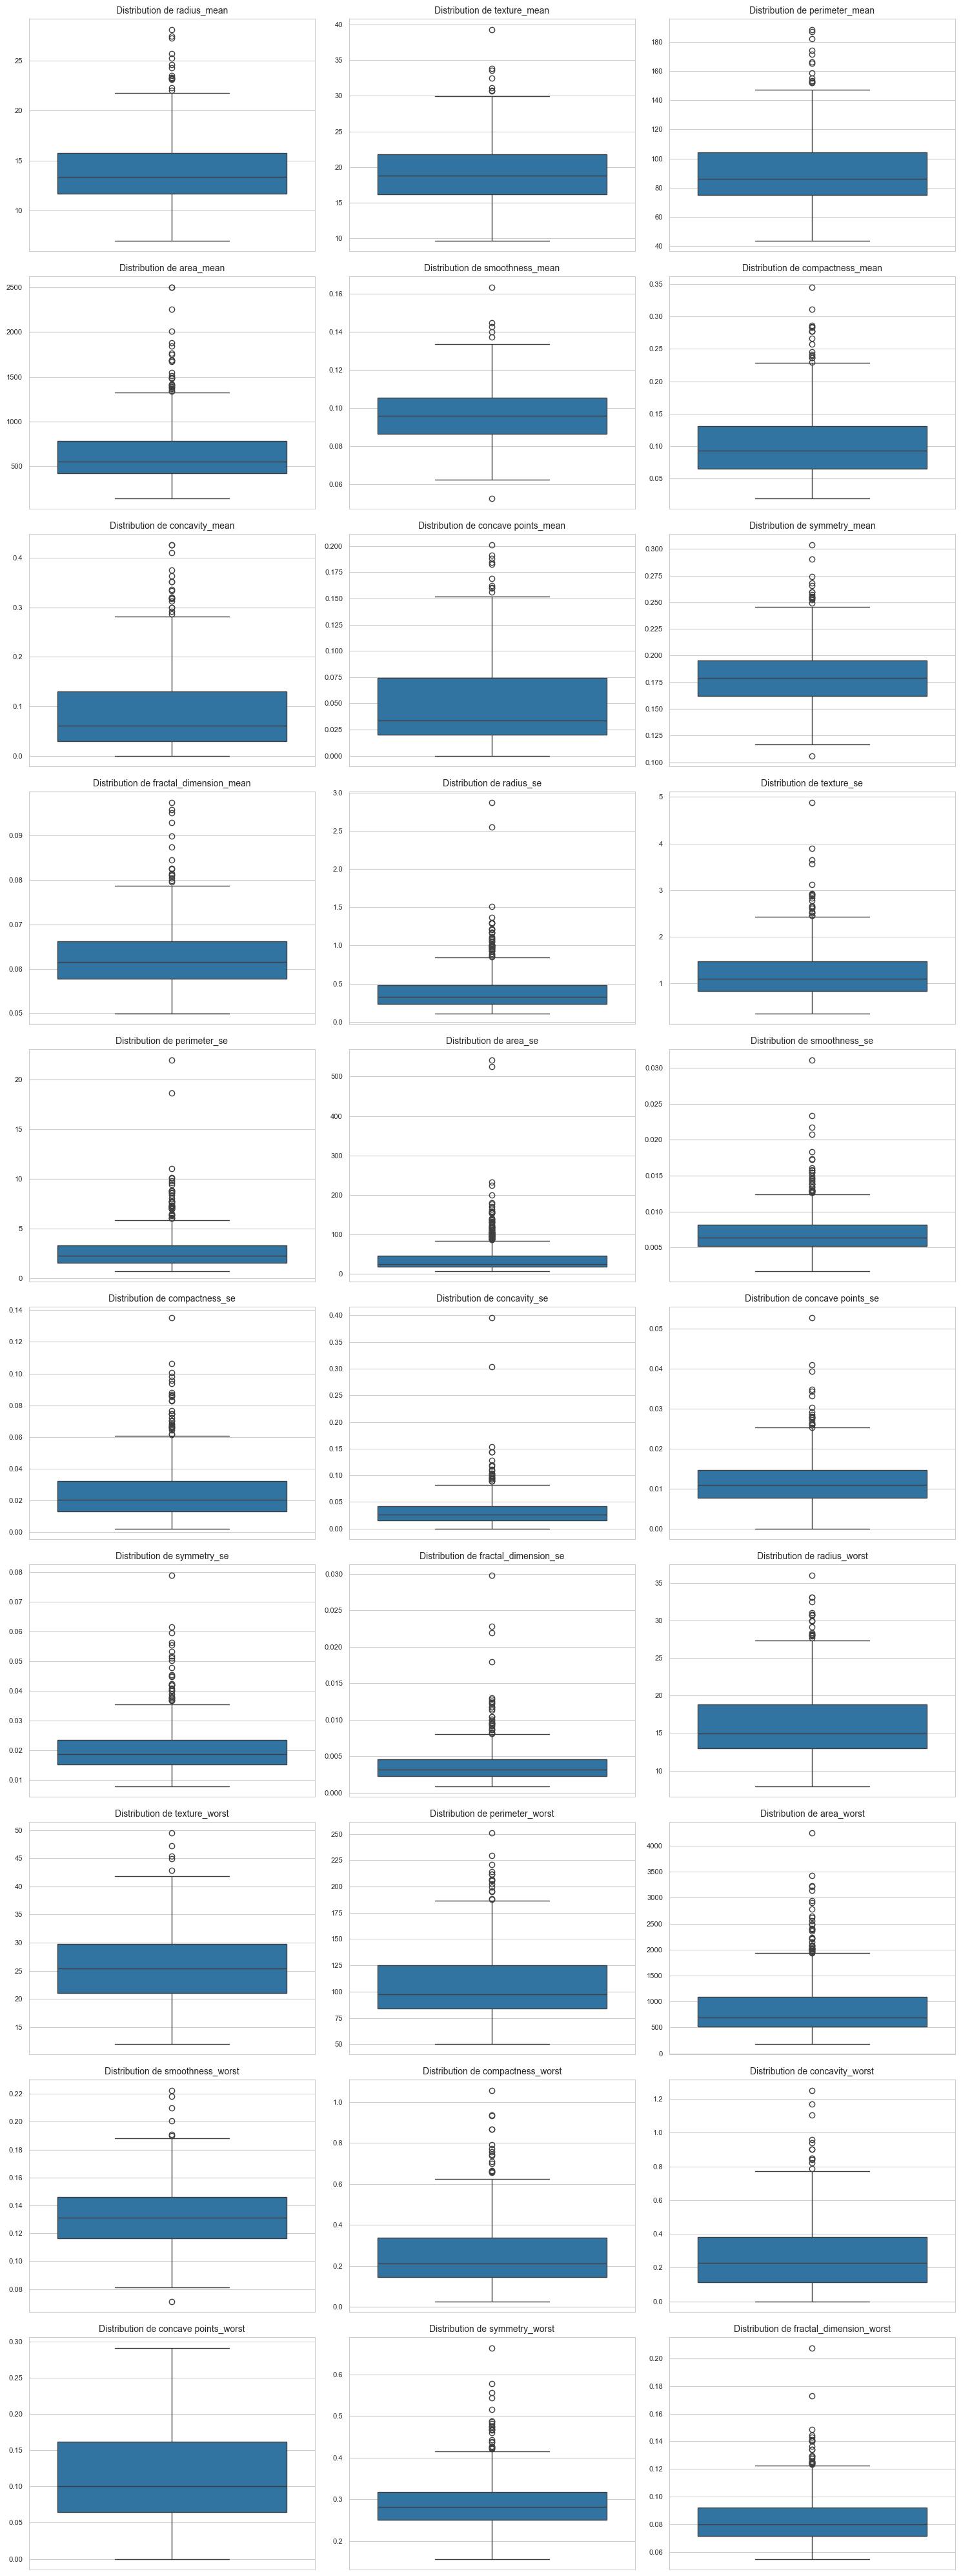

In [9]:
if 'numeric_cols' not in locals():
    numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]

n_features = len(numeric_cols)

n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'Distribution de {col}', fontsize=10)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

### 🔗 Analyse de Corrélation

**Pourquoi analyser les corrélations ?**

1. **Multicollinéarité** : Détecter les features très corrélées (redondantes)
   - Si deux features sont très corrélées, on peut en supprimer une
   - Réduit la complexité du modèle

2. **Compréhension des relations** : Comprendre comment les features sont liées
   - Corrélation positive : quand une feature augmente, l'autre aussi
   - Corrélation négative : quand une feature augmente, l'autre diminue

3. **Sélection de features** : Identifier les features les plus importantes
   - Features fortement corrélées avec la cible = potentiellement importantes

**Note** : Dans ce dataset, des corrélations élevées sont attendues car les features sont dérivées des mêmes mesures de base.


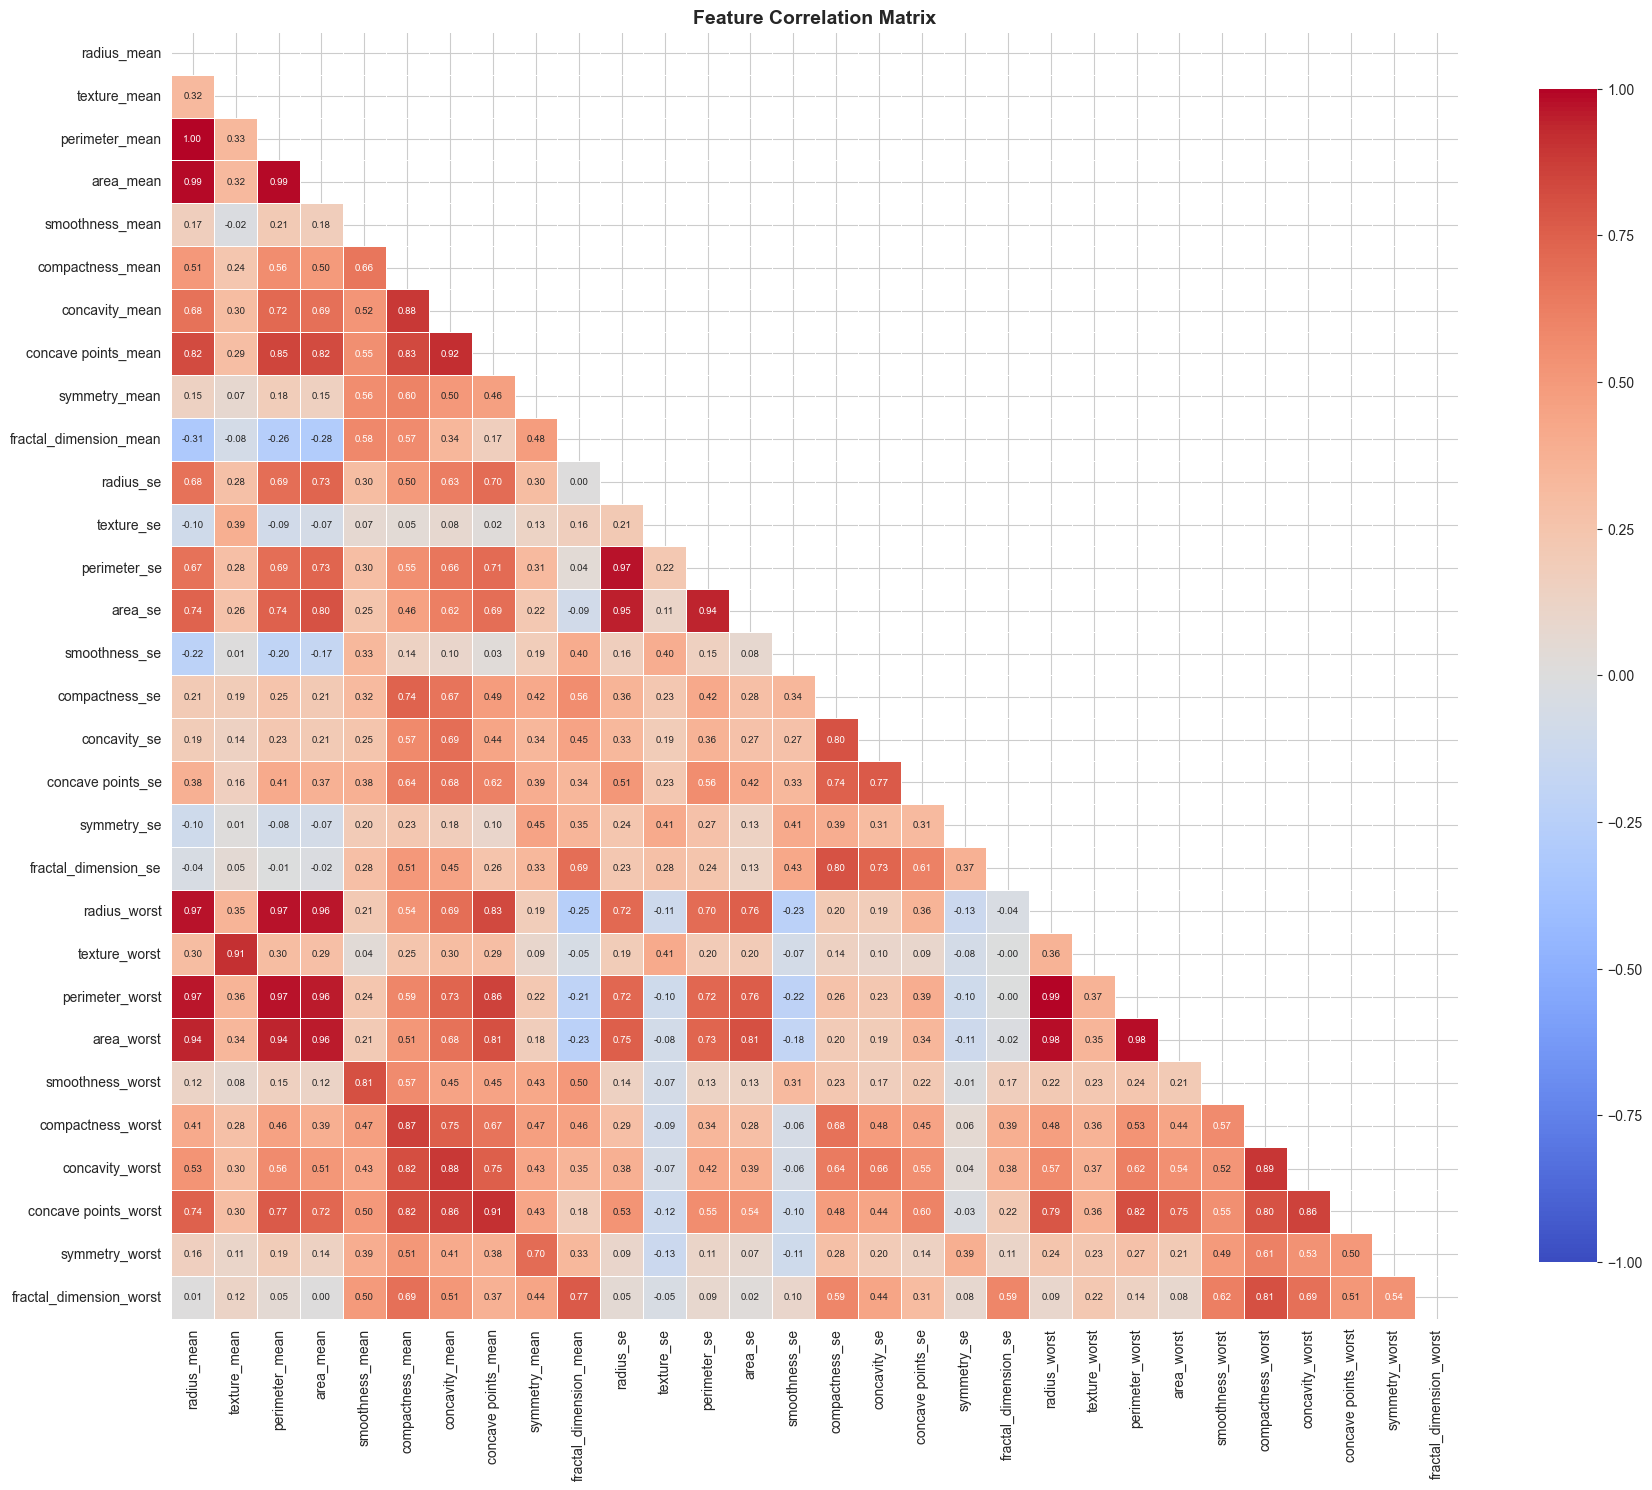

High correlations indicate related features. This is expected as features are derived from the same base measurements.


In [10]:
# ============================================================================
# MATRICE DE CORRÉLATION ENTRE LES FEATURES
# ============================================================================
# Visualise les corrélations entre toutes les paires de features

# Sélection des colonnes numériques (exclut id, Unnamed: 32, et diagnosis)
numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]
# Résultat : liste des 30 features numériques

# Calcul de la matrice de corrélation
# .corr() calcule le coefficient de corrélation de Pearson entre toutes les paires
# Valeurs entre -1 (corrélation négative parfaite) et +1 (corrélation positive parfaite)
corr_matrix = df[numeric_cols].corr()

# Création d'une grande figure pour visualiser la matrice
plt.figure(figsize=(18, 16))  # Grande taille car 30x30 features

# Création d'un masque pour n'afficher que la moitié triangulaire
# (la matrice est symétrique, donc redondante)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# np.triu() : prend la partie triangulaire supérieure
# Évite la redondance (corr(A,B) = corr(B,A))

# Création de la heatmap (carte de chaleur)
sns.heatmap(
    corr_matrix,  # Matrice de corrélation à visualiser
    mask=mask,  # Masque pour cacher la moitié (triangulaire inférieure)
    annot=True,  # Affiche les valeurs numériques dans chaque cellule
    fmt='.2f',  # Format : 2 décimales
    cmap='coolwarm',  # Palette de couleurs : bleu (négatif) → blanc (0) → rouge (positif)
    center=0,  # Centre la palette sur 0
    square=True,  # Cellules carrées (plus lisible)
    cbar_kws={"shrink": 0.8},  # Taille de la barre de couleur (légende)
    vmin=-1, vmax=1,  # Plage de valeurs : -1 à +1
    annot_kws={'size': 7},  # Taille de la police pour les annotations
    linewidths=0.5  # Largeur des lignes entre les cellules
)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("High correlations indicate related features. This is expected as features are derived from the same base measurements.")
# Les corrélations élevées sont normales ici car les features partagent les mêmes mesures de base


## 3. Préparation des Données (Data Preparation)

### 3.1 Nettoyage des Données (Data Cleaning)

**Justifications des étapes de nettoyage :**

1. **Suppression de la colonne 'id'** :
   - L'identifiant est unique pour chaque échantillon
   - N'a aucune valeur prédictive (ne peut pas aider à prédire le diagnostic)
   - Les modèles de ML n'ont pas besoin d'identifiants

2. **Suppression de 'Unnamed: 32'** :
   - Colonne vide sans information
   - Peut causer des erreurs lors de l'entraînement

3. **Encodage de 'diagnosis'** :
   - Les modèles ML nécessitent des valeurs numériques
   - Conversion 'M'/'B' → 1/0 (Malin/Bénin)
   - Facilite les calculs mathématiques

4. **Standardisation (Z-score normalization)** :
   - **Pourquoi ?** Les features ont des échelles très différentes
     - Exemple : `area_mean` peut être ~1000, tandis que `smoothness_mean` ~0.1
   - **Comment ?** Transformation : (x - moyenne) / écart-type
   - **Résultat :** Toutes les features ont moyenne=0 et écart-type=1
   - **Nécessaire pour :**
     - **SVM** : Utilise des distances, les grandes valeurs domineraient sinon
     - **KNN** : Mesure des distances entre points
     - **Réseaux de neurones** : Convergence plus rapide et stable
     - **Régression linéaire** : Évite que certaines features dominent

In [11]:
# ============================================================================
# NETTOYAGE ET PRÉPARATION DES DONNÉES + SMOTE
# ============================================================================

# --- Imports nécessaires ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# --- Étape 1 : Suppression des colonnes non pertinentes ---
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# --- Étape 2 : Encodage de la variable cible (diagnosis) ---
# 'M' (Malignant) → 1, 'B' (Benign) → 0
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

# --- Étape 3 : Séparation des features (X) et de la cible (y) ---
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# --- Étape 4 : Division Train / Test (stratifiée) ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Affichage des statistiques AVANT SMOTE
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nTrain class distribution (before SMOTE):")
print(f"  Benign (0): {np.bincount(y_train)[0]}")
print(f"  Malignant (1): {np.bincount(y_train)[1]}")

print("\nTest class distribution:")
print(f"  Benign (0): {np.bincount(y_test)[0]}")
print(f"  Malignant (1): {np.bincount(y_test)[1]}")

# --- Étape 5 : Standardisation (Z-score) ---
scaler = StandardScaler()

# Fit sur TRAIN uniquement (évite le data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nStandardization applied: mean = 0, std = 1")

# --- Étape 6 : Rééquilibrage des classes avec SMOTE (TRAIN seulement) ---
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Affichage des statistiques APRÈS SMOTE
print("\nTrain class distribution (after SMOTE):")
print(f"  Benign (0): {np.bincount(y_train_smote)[0]}")
print(f"  Malignant (1): {np.bincount(y_train_smote)[1]}")

Train set: 398 samples (69.9%)
Test set: 171 samples (30.1%)

Train class distribution (before SMOTE):
  Benign (0): 250
  Malignant (1): 148

Test class distribution:
  Benign (0): 107
  Malignant (1): 64

Standardization applied: mean = 0, std = 1

Train class distribution (after SMOTE):
  Benign (0): 250
  Malignant (1): 250


## 4. Modélisation (Modeling)

### 🎯 Objectif
Implémenter et comparer **6 algorithmes de machine learning** différents pour identifier le meilleur modèle de classification.

### 📋 Algorithmes Implémentés

1. **Régression Linéaire** (utilisée comme classifieur)
   - Modèle simple et interprétable
   - Base de comparaison

2. **Régression Softmax** (Logistic Regression)
   - Classifieur linéaire probabiliste
   - Optimisé pour la classification binaire

3. **Multi-Layer Perceptron (MLP)**
   - Réseau de neurones profond (3 couches cachées)
   - Capture des patterns non-linéaires

4. **Support Vector Machine (L2-SVM)**
   - Trouve la meilleure frontière de séparation
   - Kernel RBF pour non-linéarité

5. **K-Nearest Neighbors (KNN)**
   - L1 (distance Manhattan) et L2 (distance Euclidienne)
   - Classification basée sur les voisins

6. **GRU-SVM** (Modèle hybride)
   - Deep Learning (GRU) + SVM
   - Architecture la plus complexe


### 4.1 Régression Linéaire (utilisée comme Classifieur)

#### 🎯 Concept
La régression linéaire est normalement utilisée pour la **régression** (prédire une valeur continue), mais on peut l'utiliser pour la **classification binaire** en :
1. Prédire une valeur continue (probabilité)
2. Appliquer un seuil (0.5) pour classer en 0 ou 1

#### 📐 Formule Mathématique
```
y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
```
- **w** : poids (coefficients) à apprendre
- **x** : features (caractéristiques)
- **b** : biais (intercept)

#### ⚙️ Algorithme : SGD (Stochastic Gradient Descent)
- **Gradient Descent** : Optimise les poids en minimisant l'erreur
- **Stochastic** : Utilise un sous-échantillon aléatoire à chaque itération (plus rapide)
- **Avantage** : Efficace sur de grands datasets

#### 🔧 Hyperparamètres choisis
- `loss='squared_error'` : Fonction de perte (erreur quadratique)
- `learning_rate='constant'` : Taux d'apprentissage constant
- `eta0=1e-3` : Valeur du taux d'apprentissage (0.001)
- `max_iter=3000` : Nombre maximum d'itérations
- `random_state=42` : Pour la reproductibilité


In [12]:
# ============================================================================
# MODÈLE 1 : RÉGRESSION LINÉAIRE (comme classifieur)
# ============================================================================

# Valeurs à tester
learning_rates = [1e-4, 1e-3, 1e-2]
iterations = [1000, 3000, 5000]
best_auc_lr = -np.inf
best_eta = None
best_iter = None


for eta in learning_rates:
    for it in iterations:

        # Création du modèle de régression linéaire avec SGD
        linear_model = SGDRegressor(
            loss='squared_error',        # Fonction de perte : erreur quadratique (L2)
            # Formule MSE : (y_pred - y_true)²
            learning_rate='constant',    # Taux d'apprentissage constant (ne change pas)
            eta0=eta,                    # Valeur initiale du taux d'apprentissage
            # Plus petit = apprentissage plus lent mais plus stable
            max_iter=it,                 # Nombre maximum d'itérations (époques)
            random_state=42              # Graine aléatoire pour reproductibilité
        )

        # Entraînement du modèle sur les données d'entraînement
        linear_model.fit(X_train_scaled, y_train)
        # Le modèle apprend les poids (w) et le biais (b) qui minimisent l'erreur

        # --- Prédictions sur le test set ---
        # Prédiction de valeurs continues (probabilités brutes)
        linear_y_test_continuous = linear_model.predict(X_test_scaled)
        # Ces valeurs peuvent être < 0 ou > 1, donc on applique un seuil

        # Conversion en classes binaires : si >= 0.5 → classe 1 (malin), sinon → classe 0 (bénin)
        lr_y_test_pred = (linear_y_test_continuous >= 0.5).astype(int)
        # .astype(int) convertit True/False en 1/0

        # --- Conversion des prédictions en probabilités [0, 1] ---
        # Les valeurs prédites ne sont pas dans [0, 1], donc on les normalise
        from sklearn.preprocessing import MinMaxScaler  # Normalise entre min et max

        prob_scaler = MinMaxScaler()  # Création du scaler pour normaliser entre 0 et 1

        # On calcule les prédictions sur le train pour apprendre min/max
        linear_y_train_continuous = linear_model.predict(X_train_scaled)
        # .reshape(-1, 1) : transforme en colonne (nécessaire pour MinMaxScaler)
        prob_scaler.fit(linear_y_train_continuous.reshape(-1, 1))
        # fit() apprend le min et max des valeurs d'entraînement

        # Application de la normalisation sur les prédictions de test
        lr_y_test_proba = prob_scaler.transform(
            linear_y_test_continuous.reshape(-1, 1)
        ).flatten()
        # transform() : applique la normalisation (valeur - min) / (max - min)
        # .flatten() : transforme la colonne en tableau 1D
        # Résultat : probabilités entre 0 et 1
        auc = roc_auc_score(y_test, lr_y_test_proba)

        if auc > best_auc_lr:
            best_auc_lr = auc
            best_eta = eta
            best_iter = it




### 4.2 Régression Softmax (Logistic Regression)

#### 🎯 Concept
La régression softmax (ou régression logistique) est **spécialement conçue pour la classification**.

#### 📐 Formule Mathématique
```
P(y=1|x) = 1 / (1 + e^(-z))
où z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
```
- **Sortie** : Probabilité directement entre 0 et 1 (pas besoin de normalisation)
- **Fonction sigmoïde** : Transforme la sortie linéaire en probabilité

#### ⚙️ Algorithme : Logistic Regression
- **Log Loss** : Fonction de perte optimale pour la classification binaire
- **Formule** : -[y*log(ŷ) + (1-y)*log(1-ŷ)]
- **Avantage** : Punit fortement les erreurs de confiance (prédire 0.9 pour une classe 0)

#### 🔧 Hyperparamètres
- `C` : Inverse de la force de régularisation (0.01 à 100)
- `solver` : Algorithme d'optimisation ('lbfgs', 'liblinear', 'newton-cg')
- `max_iter` : Nombre maximum d'itérations (1000, 3000, 5000)


In [13]:
# ============================================================================
# MODÈLE 2 : RÉGRESSION SOFTMAX (Logistic Regression)
# ============================================================================

# Valeurs à tester
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ['lbfgs', 'liblinear', 'newton-cg']
iterations = [1000, 3000, 5000]
best_auc_softmax = -np.inf
best_softmax_C = None
best_softmax_solver = None
best_softmax_max_iter = None


for C_val in C_values:
    for solver in solvers:
        for it in iterations:

            # Création du modèle de régression logistique
            softmax_model = LogisticRegression(
                C=C_val,                    # Inverse de la force de régularisation
                # Plus C est grand, moins de régularisation (risque d'overfitting)
                solver=solver,              # Algorithme d'optimisation
                # 'lbfgs' : bon pour petits datasets, 'liblinear' : bon pour binaire
                max_iter=it,               # Nombre maximum d'itérations
                random_state=42            # Reproductibilité
            )

            # Entraînement du modèle
            softmax_model.fit(X_train_smote, y_train_smote)
            # Le modèle apprend les poids qui maximisent la probabilité des classes correctes

            # --- Prédictions sur le test set ---
            # Probabilités : probabilité que chaque échantillon soit de la classe 1 (malin)
            softmax_y_test_proba = softmax_model.predict_proba(X_test_scaled)[:, 1]
            # predict_proba() retourne un array 2D : [[P(classe0), P(classe1)], ...]
            # [:, 1] : prend seulement la probabilité de la classe 1 (malin)

            # Classes prédites : 0 (bénin) ou 1 (malin)
            softmax_y_test_pred = softmax_model.predict(X_test_scaled)
            # predict() retourne directement la classe avec la plus haute probabilité
            auc = roc_auc_score(y_test, softmax_y_test_proba)

            if auc > best_auc_softmax:
                best_auc_softmax = auc
                best_softmax_C = C_val
                best_softmax_solver = solver
                best_softmax_max_iter = it





### 4.3 Multi-Layer Perceptron (MLP) - Réseau de Neurones Profond

#### 🎯 Concept
Réseau de neurones artificiels avec **plusieurs couches cachées** pour capturer des patterns non-linéaires complexes.

#### 🏗️ Architecture
```
Input (30 features)
    ↓
Hidden Layer 1 (500 neurones)
    ↓
Hidden Layer 2 (500 neurones)
    ↓
Hidden Layer 3 (500 neurones)
    ↓
Output (1 neurone, sigmoid)
```

#### ⚙️ Fonctionnement
- **Forward propagation** : Les données passent de l'input vers l'output
- **Backpropagation** : Les erreurs remontent pour ajuster les poids
- **Activation ReLU** : Introduit la non-linéarité
- **Early stopping** : Arrête si pas d'amélioration (évite le surapprentissage)

#### 🔧 Hyperparamètres
- `hidden_layer_sizes=(500, 500, 500)` : 3 couches de 500 neurones chacune
- `learning_rate_init=1e-2` : Taux d'apprentissage initial = 0.01 (plus élevé que SGD)
- `alpha=0.01` : Régularisation L2 (pénalise les grands poids)
- `early_stopping=True` : Arrêt anticipé si validation ne s'améliore pas
- `validation_fraction=0.1` : 10% du train utilisé pour validation


In [14]:
# ============================================================================
# MODÈLE 3 : MULTI-LAYER PERCEPTRON (MLP)
# ============================================================================

# Valeurs à tester
learning_rates = [1e-3, 1e-2]
iterations = [1000, 3000, 5000]
hidden_layers = [(200, 200), (500, 500, 500), (300, 300, 300)]
alphas = [1e-4, 1e-2, 1e-1]
best_auc_mlp = -np.inf
best_mlp_hidden = None
best_mlp_alpha = None


for hls in hidden_layers:
    for alpha in alphas:
        for lr in learning_rates:
            for it in iterations:

                # Création du réseau de neurones avec 3 couches cachées
                mlp_model = MLPClassifier(
                    hidden_layer_sizes=hls,  # Architecture : couches cachées
                    # Plus de neurones = capacité à apprendre des patterns plus complexes
                    # Mais aussi risque de surapprentissage

                    learning_rate_init=lr,  # Taux d'apprentissage initial
                    # Plus élevé que SGD (0.001) car le MLP utilise un scheduler adaptatif

                    alpha=alpha,  # Régularisation L2 (weight decay)
                    # Pénalise les grands poids : α * Σ(w²)
                    # Réduit le surapprentissage en gardant les poids petits

                    max_iter=it,  # Nombre maximum d'itérations

                    early_stopping=True,  # Arrêt anticipé si validation ne s'améliore plus
                    # Évite le surapprentissage en arrêtant avant que le modèle mémorise

                    random_state=42,  # Reproductibilité

                    verbose=0,  # Pas d'affichage pendant l'entraînement (0 = silencieux)

                    validation_fraction=0.1  # 10% des données d'entraînement pour validation
                    # Utilisé pour l'early stopping
                )

                # Entraînement du modèle
                mlp_model.fit(X_train_smote, y_train_smote)
                # Le modèle apprend les poids de toutes les couches via backpropagation

                # --- Prédictions sur le test set ---
                mlp_y_test_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]  # Probabilités
                mlp_y_test_pred = mlp_model.predict(X_test_scaled)  # Classes prédites
                auc = roc_auc_score(y_test, mlp_y_test_proba)

                if auc > best_auc_mlp:
                    best_auc_mlp = auc
                    best_mlp_hidden = hls
                    best_mlp_alpha = alpha

### 4.4 Support Vector Machine (L2-SVM)

#### 🎯 Concept
Trouve la **meilleure frontière de séparation** (hyperplan) entre les classes en maximisant la marge.

#### 📐 Principe
- **Support Vectors** : Points les plus proches de la frontière
- **Marge** : Distance entre la frontière et les points les plus proches
- **Kernel RBF** : Transforme les données dans un espace de plus haute dimension pour séparer non-linéairement

#### 🔧 Hyperparamètres
- `C=5` : Paramètre de régularisation
  - **C petit** : Plus de régularisation, frontière plus simple
  - **C grand** : Moins de régularisation, frontière plus complexe (risque de surapprentissage)
- `kernel='rbf'` : Radial Basis Function (gaussien)
  - Permet des frontières non-linéaires
  - Formule : K(x,y) = exp(-γ||x-y||²)
- `gamma='scale'` : Auto-calcule γ = 1/(n_features * variance)
- `probability=True` : Permet d'obtenir des probabilités (utilise Platt scaling)


In [15]:
# ============================================================================
# MODÈLE 4 : SUPPORT VECTOR MACHINE (L2-SVM)
# ============================================================================

# Valeurs à tester
C_values = [0.1, 1, 5, 10]
iterations = [1000, 3000, 5000]
best_auc_svm = -np.inf
best_svm_C = None


for C_val in C_values:
    for it in iterations:

        # Création du modèle SVM
        svm_model = SVC(
            C=C_val,  # Paramètre de régularisation (selon Table 1 du papier)
            # C contrôle le compromis entre marge large et erreurs de classification
            # C=5 : tolère quelques erreurs pour avoir une marge plus large

            kernel='rbf',  # Radial Basis Function (kernel gaussien)
            # Transforme les données dans un espace de dimension infinie
            # Permet de séparer des données non-linéairement séparables

            gamma='scale',  # Paramètre du kernel RBF
            # 'scale' : calcule automatiquement γ = 1/(n_features * variance(X))
            # Contrôle l'influence de chaque point d'entraînement

            probability=True,  # Active l'estimation de probabilités
            # Utilise Platt scaling (régression logistique sur les scores du SVM)
            # Nécessaire pour obtenir predict_proba()

            random_state=42,  # Reproductibilité

            max_iter=it  # Nombre maximum d'itérations pour la convergence
        )

        # Entraînement du modèle
        svm_model.fit(X_train_scaled, y_train)
        # Le SVM trouve les support vectors et construit l'hyperplan optimal

        # --- Prédictions sur le test set ---
        svm_y_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probabilités
        svm_y_test_pred = svm_model.predict(X_test_scaled)  # Classes prédites
        auc = roc_auc_score(y_test, svm_y_test_proba)
        if auc > best_auc_svm:
          best_auc_svm = auc
          best_svm_C = C_val



### 4.5 K-Nearest Neighbors (KNN) - Plus Proches Voisins

#### 🎯 Concept
Classifie un point selon la **majorité des classes** de ses **k plus proches voisins** dans l'espace des features.

#### 📐 Principe
1. Pour un nouvel échantillon, trouve les k échantillons les plus proches
2. Regarde les classes de ces k voisins
3. Attribue la classe majoritaire

#### 📏 Distances
- **L1 (Manhattan)** : `d = |x₁-y₁| + |x₂-y₂| + ...`
  - Distance en "blocs de ville"
  - Plus robuste aux outliers
  
- **L2 (Euclidienne)** : `d = √[(x₁-y₁)² + (x₂-y₂)² + ...]`
  - Distance "à vol d'oiseau"
  - Plus sensible aux grandes différences

#### 🔧 Hyperparamètres
- `n_neighbors=1` : Utilise seulement le plus proche voisin (1-NN)
  - **Avantage** : Simple et souvent performant
  - **Inconvénient** : Sensible au bruit
- `metric='minkowski'` : Métrique généralisée
- `p=1` : Distance L1 (Manhattan)
- `p=2` : Distance L2 (Euclidienne)


In [16]:
# ============================================================================
# MODÈLE 5 : K-NEAREST NEIGHBORS (KNN)
# ============================================================================
# On teste deux distances différentes : L1 (Manhattan) et L2 (Euclidienne)

# Valeurs à tester
k_values = [1, 3, 5, 7, 9]
best_auc_knn_l1 = -np.inf
best_knn_l1_k = None
best_auc_knn_l2 = -np.inf
best_knn_l2_k = None



for k in k_values:

    # --- KNN avec distance L1 (Manhattan) ---
    knn_l1 = KNeighborsClassifier(
        n_neighbors=k,  # Utilise k plus proches voisins
        # Plus simple et souvent performant, mais sensible au bruit

        metric='minkowski',  # Métrique généralisée (L1 et L2 sont des cas particuliers)
        p=1  # p=1 → Distance L1 (Manhattan)
        # Formule : d = |x₁-y₁| + |x₂-y₂| + ... + |xₙ-yₙ|
        # Plus robuste aux valeurs aberrantes
    )
    knn_l1.fit(X_train_scaled, y_train)  # "Entraînement" : stocke les données d'entraînement
    # Note : KNN est un "lazy learner" - il ne fait pas vraiment d'entraînement,
    # il stocke juste les données pour les comparer plus tard

    knn_l1_y_test_pred = knn_l1.predict(X_test_scaled)  # Classes prédites
    knn_l1_y_test_proba = knn_l1.predict_proba(X_test_scaled)[:, 1]  # Probabilités
    # Probabilité = proportion de voisins de chaque classe

    # --- KNN avec distance L2 (Euclidienne) ---
    knn_l2 = KNeighborsClassifier(
        n_neighbors=k,  # Même nombre de voisins
        metric='minkowski',  # Même métrique généralisée
        p=2  # p=2 → Distance L2 (Euclidienne)
        # Formule : d = √[(x₁-y₁)² + (x₂-y₂)² + ... + (xₙ-yₙ)²]
        # Distance "à vol d'oiseau", plus sensible aux grandes différences
    )
    knn_l2.fit(X_train_scaled, y_train)

    knn_l2_y_test_pred = knn_l2.predict(X_test_scaled)
    knn_l2_y_test_proba = knn_l2.predict_proba(X_test_scaled)[:, 1]

    # Comparaison : L1 vs L2 peut donner des résultats différents selon la distribution des données
    auc = roc_auc_score(y_test, knn_l1_y_test_proba)

    if auc > best_auc_knn_l1:
      best_auc_knn_l1 = auc
      best_knn_l1_k = k
    auc = roc_auc_score(y_test, knn_l2_y_test_proba)
    if auc > best_auc_knn_l2:
      best_auc_knn_l2 = auc
      best_knn_l2_k = k

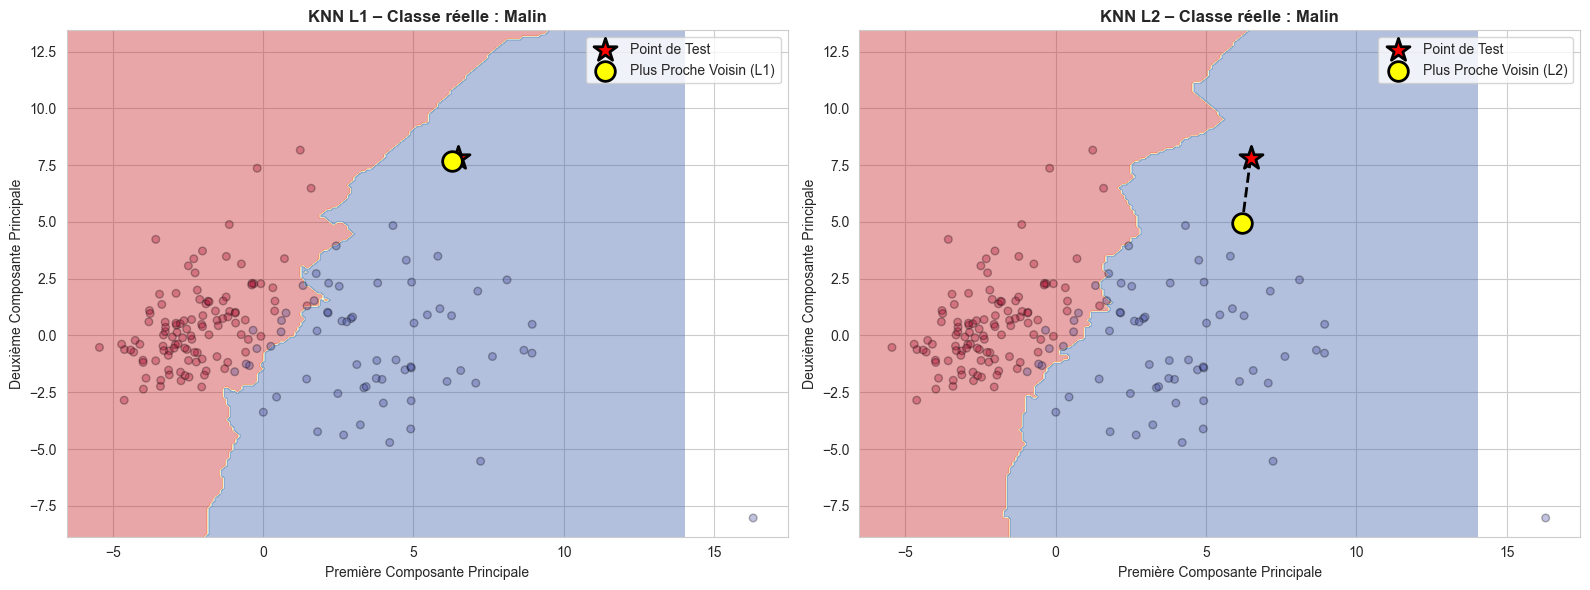

In [17]:
# ============================================================================
# VISUALISATION EN ACTION : KNN (K-Nearest Neighbors)
# ============================================================================
# Visualisation des voisins pour KNN L1 et KNN L2 (2 graphes uniquement)

from sklearn.decomposition import PCA

# PCA pour projection 2D (visualisation uniquement)
pca = PCA(n_components=2, random_state=42)

X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

# Grille pour la frontière de décision
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sélection d'un point de test aléatoire
test_point_idx = np.random.choice(len(X_test_scaled))
test_point = X_test_scaled[test_point_idx:test_point_idx + 1]
test_point_2d = pca.transform(test_point)[0]
test_point_label = y_test.iloc[test_point_idx] if hasattr(y_test, 'iloc') else y_test[test_point_idx]

# ================================
# Graphique 1 : KNN L1
# ================================
ax1 = axes[0]

grid_pca = pca.inverse_transform(grid_points)
grid_pred_l1 = knn_l1.predict(grid_pca)
Z_l1 = grid_pred_l1.reshape(xx.shape)

ax1.contourf(xx, yy, Z_l1, alpha=0.4, cmap='RdYlBu')

# Plus proche voisin (L1)
distances_l1, indices_l1 = knn_l1.kneighbors(test_point, n_neighbors=1)
nearest_neighbor_l1 = X_train_scaled[indices_l1[0][0]]
nearest_neighbor_l1_2d = pca.transform(nearest_neighbor_l1.reshape(1, -1))[0]

ax1.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
            c=y_test, cmap='RdYlBu', edgecolors='black', s=30, alpha=0.3)

ax1.scatter(test_point_2d[0], test_point_2d[1],
            s=300, c='red', marker='*', edgecolors='black',
            linewidth=2, label='Point de Test', zorder=5)

ax1.scatter(nearest_neighbor_l1_2d[0], nearest_neighbor_l1_2d[1],
            s=200, c='yellow', marker='o', edgecolors='black',
            linewidth=2, label='Plus Proche Voisin (L1)', zorder=5)

ax1.plot([test_point_2d[0], nearest_neighbor_l1_2d[0]],
         [test_point_2d[1], nearest_neighbor_l1_2d[1]],
         'k--', linewidth=2)

ax1.set_title(f'KNN L1 – Classe réelle : {"Malin" if test_point_label == 1 else "Bénin"}',
              fontweight='bold')
ax1.set_xlabel('Première Composante Principale')
ax1.set_ylabel('Deuxième Composante Principale')
ax1.legend()

# ================================
# Graphique 2 : KNN L2
# ================================
ax2 = axes[1]

grid_pred_l2 = knn_l2.predict(grid_pca)
Z_l2 = grid_pred_l2.reshape(xx.shape)

ax2.contourf(xx, yy, Z_l2, alpha=0.4, cmap='RdYlBu')

distances_l2, indices_l2 = knn_l2.kneighbors(test_point, n_neighbors=1)
nearest_neighbor_l2 = X_train_scaled[indices_l2[0][0]]
nearest_neighbor_l2_2d = pca.transform(nearest_neighbor_l2.reshape(1, -1))[0]

ax2.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
            c=y_test, cmap='RdYlBu', edgecolors='black', s=30, alpha=0.3)

ax2.scatter(test_point_2d[0], test_point_2d[1],
            s=300, c='red', marker='*', edgecolors='black',
            linewidth=2, label='Point de Test', zorder=5)

ax2.scatter(nearest_neighbor_l2_2d[0], nearest_neighbor_l2_2d[1],
            s=200, c='yellow', marker='o', edgecolors='black',
            linewidth=2, label='Plus Proche Voisin (L2)', zorder=5)

ax2.plot([test_point_2d[0], nearest_neighbor_l2_2d[0]],
         [test_point_2d[1], nearest_neighbor_l2_2d[1]],
         'k--', linewidth=2)

ax2.set_title(f'KNN L2 – Classe réelle : {"Malin" if test_point_label == 1 else "Bénin"}',
              fontweight='bold')
ax2.set_xlabel('Première Composante Principale')
ax2.set_ylabel('Deuxième Composante Principale')
ax2.legend()

plt.tight_layout()
plt.show()


### 4.6 GRU-SVM (Modèle Hybride Deep Learning + SVM)

#### 🎯 Concept : Architecture Hybride en 2 Étapes

Ce modèle combine deux techniques puissantes :

1. **GRU (Gated Recurrent Unit)** : Réseau de neurones récurrent
   - Extrait des **features complexes** (représentations abstraites)
   - Traite les données comme une séquence temporelle
   
2. **SVM (Support Vector Machine)** : Classifieur final
   - Utilise les features extraites par le GRU
   - Trouve la meilleure frontière de décision

#### 🏗️ Architecture du GRU

```
Input (30 features × 1)
    ↓
GRU Layer (128 units)      ← Extrait des features complexes
    ↓
Dropout (0.5)              ← Régularisation (évite le surapprentissage)
    ↓
Dense Layer (32 units, ReLU) ← Couche fully-connected
    ↓
Dropout (0.5)              ← Régularisation
    ↓
Dense Output (1 unit, Sigmoid) ← Prédiction finale
```

**Extraction des features** : On prend la sortie de la couche Dense(32) avant la dernière couche

#### 📊 Pourquoi cette Architecture ?

- **GRU** : Capture des patterns complexes dans les données
- **Dropout** : Désactive aléatoirement 50% des neurones → prévient le surapprentissage
- **SVM final** : Utilise les features extraites pour une classification optimale

#### 🔧 Hyperparamètres (selon Table 1 du papier)

- **Cell Size (GRU)** : 128 unités
- **Dropout** : 0.5 (50% des neurones désactivés)
- **Batch Size** : 128 échantillons par batch
- **Learning Rate** : 1e-3 (0.001)
- **Optimizer** : Adam (adaptatif)
- **Early Stopping** : Arrêt si pas d'amélioration pendant 30 époques


In [18]:
# ============================================================================
# MODÈLE 6 : GRU-SVM (Modèle Hybride)
# ============================================================================

# Valeurs à tester pour C
C_values = [0.1, 1, 5, 10]
best_auc_gru = -np.inf
best_gru_units = None
best_gru_svm_C = None


for C_val in C_values:

    if TENSORFLOW_AVAILABLE:
        # --- Étape 1 : Préparation des données pour le GRU ---
        # Le GRU attend des données en 3D : (samples, timesteps, features)
        # On reshape pour avoir : (samples, features, 1) = traiter chaque feature comme un timestep
        n_features = X_train_scaled.shape[1]  # Nombre de features (30)

        # Reshape : (398, 30) → (398, 30, 1)
        # Format attendu par les réseaux récurrents : (batch, timesteps, features)
        X_train_gru = X_train_scaled.reshape(X_train_scaled.shape[0], n_features, 1)
        X_test_gru = X_test_scaled.reshape(X_test_scaled.shape[0], n_features, 1)

        # --- Étape 2 : Construction de l'architecture GRU ---
        # Hyperparamètres selon Table 1 du papier :
        # Cell Size: 128, Dropout: 0.5, Batch Size: 128, Learning Rate: 1e-3
        gru_model = Sequential([
            Input(shape=(n_features, 1)),  # Couche d'entrée explicite (30 features, 1 timestep)

            GRU(128, return_sequences=False),  # 128 neurones GRU
            # return_sequences=False : retourne seulement la dernière sortie

            Dropout(0.5),  # Régularisation

            Dense(32, activation='relu'),  # Couche fully-connected

            Dropout(0.5),

            Dense(1, activation='sigmoid')  # Couche de sortie
        ])

        # --- Étape 3 : Compilation du modèle ---
        gru_model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # --- Étape 4 : Configuration de l'Early Stopping ---
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=1
        )

        # --- Étape 5 : Entraînement du modèle GRU ---
        gru_model.fit(
            X_train_gru, y_train,
            epochs=500,
            batch_size=128,
            validation_split=0.2,
            verbose=1,
            callbacks=[early_stopping]
        )

        # --- Étape 6 : Extraction des features avec le GRU ---
        from tensorflow.keras.models import Model

        model_input = gru_model.layers[0].input

        feature_extractor = Model(
            inputs=model_input,
            outputs=gru_model.layers[-3].output
        )

        gru_train_features = feature_extractor.predict(X_train_gru, verbose=1)
        gru_test_features = feature_extractor.predict(X_test_gru, verbose=1)

        # --- Étape 7 : Entraînement du SVM sur les features extraites ---
        gru_svm_model = SVC(
            kernel='rbf',
            C=C_val,  # Paramètre de régularisation testé
            probability=True,
            random_state=42
        )
        gru_svm_model.fit(gru_train_features, y_train)

        # --- Étape 8 : Prédictions finales ---
        gru_svm_y_test_pred = gru_svm_model.predict(gru_test_features)
        gru_svm_y_test_proba = gru_svm_model.predict_proba(gru_test_features)[:, 1]

    else:
        gru_svm_model = None
        gru_svm_y_test_pred = None
        gru_svm_y_test_proba = None
        print("TensorFlow non disponible - Le modèle GRU-SVM ne peut pas être entraîné")
    auc = roc_auc_score(y_test, gru_svm_y_test_proba)

    if auc > best_auc_gru:
        best_auc_gru = auc
        best_gru_units = 128
        best_gru_svm_C = C_val




Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.4371 - loss: 0.7056 - val_accuracy: 0.8625 - val_loss: 0.6773
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7767 - loss: 0.6600 - val_accuracy: 0.8375 - val_loss: 0.6411
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8333 - loss: 0.6269 - val_accuracy: 0.8375 - val_loss: 0.6030
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8333 - loss: 0.5799 - val_accuracy: 0.8375 - val_loss: 0.5596
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8396 - loss: 0.5425 - val_accuracy: 0.8750 - val_loss: 0.5036
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8679 - loss: 0.4701 - val_accuracy: 0.9125 - val_loss: 0.4275
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8805 - loss: 0.3921 - val_accuracy: 0.9125 - val_loss: 0.3500
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8994 - loss: 0.3300 - val_accuracy: 0.8875 - val_lo

## 5. Évaluation (Evaluation)

### 🎯 Objectif
Comparer les performances de tous les modèles sur l'ensemble de test en utilisant plusieurs métriques.

### 📊 Métriques Utilisées

1. **Accuracy (Précision)** : Pourcentage de prédictions correctes
2. **ROC-AUC** : Aire sous la courbe ROC (capacité à distinguer les classes)
3. **Recall (Rappel/Sensibilité)** : Capacité à détecter les vrais positifs
4. **Precision (Précision)** : Proportion de vrais positifs parmi les prédictions positives
5. **F1-Score** : Moyenne harmonique de précision et rappel
6. **Specificity (Spécificité)** : Capacité à détecter les vrais négatifs
7. **FPR (False Positive Rate)** : Taux de faux positifs
8. **FNR (False Negative Rate)** : Taux de faux négatifs
9. **TPR (True Positive Rate)** : Taux de vrais positifs (= Recall)


In [19]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    recall_score, precision_score, f1_score
)
import pandas as pd

# ============================================================================
# FONCTION DE CALCUL DES MÉTRIQUES
# ============================================================================

def calculate_metrics(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'recall': recall_score(y_true, y_pred, pos_label=1),
        'precision': precision_score(y_true, y_pred, pos_label=1),
        'f1_score': f1_score(y_true, y_pred, pos_label=1),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0.0,
        'FNR': fn / (fn + tp) if (fn + tp) > 0 else 0.0,
        'TPR': tp / (tp + fn) if (tp + fn) > 0 else 0.0
    }

# ============================================================================
# CALCUL DES MÉTRIQUES POUR TOUS LES MODÈLES
# ============================================================================

test_results = {
    'Linear Regression': calculate_metrics(y_test, lr_y_test_pred, lr_y_test_proba),
    'Softmax Regression': calculate_metrics(y_test, softmax_y_test_pred, softmax_y_test_proba),
    'MLP': calculate_metrics(y_test, mlp_y_test_pred, mlp_y_test_proba),
    'L2-SVM': calculate_metrics(y_test, svm_y_test_pred, svm_y_test_proba),
    'L1-NN': calculate_metrics(y_test, knn_l1_y_test_pred, knn_l1_y_test_proba),
    'L2-NN': calculate_metrics(y_test, knn_l2_y_test_pred, knn_l2_y_test_proba)
}

if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    test_results['GRU-SVM'] = calculate_metrics(
        y_test, gru_svm_y_test_pred, gru_svm_y_test_proba
    )

results_df = pd.DataFrame(test_results).T
print(results_df)

# ============================================================================
# MEILLEURS HYPERPARAMÈTRES PAR MODÈLE
# ============================================================================

best_hyperparameters = {
    "Linear Regression": {
        "eta0": best_eta,
        "max_iter": best_iter
    },
    "Softmax Regression": {
        "C": best_softmax_C,
        "solver": best_softmax_solver
    },
    "MLP": {
        "hidden_layer_sizes": best_mlp_hidden,
        "alpha": best_mlp_alpha
    },
    "L2-SVM": {
        "C": best_svm_C,
        "kernel": "linear"
    },
    "L1-NN": {
        "k": best_knn_l1_k,
        "metric": "manhattan"
    },
    "L2-NN": {
        "k": best_knn_l2_k,
        "metric": "euclidean"
    }
}

if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    best_hyperparameters["GRU-SVM"] = {
        "GRU_units": best_gru_units,
        "SVM_C": best_gru_svm_C
    }

# ============================================================================
# AFFICHAGE FINAL DES MEILLEURS HYPERPARAMÈTRES
# ============================================================================

print("\n================ BEST HYPERPARAMETERS ================\n")

for model, params in best_hyperparameters.items():
    print(f"{model}:")
    for p, v in params.items():
        print(f"  - {p}: {v}")
    print()


                    accuracy   roc_auc    recall  precision  f1_score  \
Linear Regression   0.906433  0.975613  0.750000   1.000000  0.857143   
Softmax Regression  0.947368  0.980870  0.890625   0.966102  0.926829   
MLP                 0.976608  0.993721  0.984375   0.954545  0.969231   
L2-SVM              0.970760  0.995473  0.937500   0.983607  0.960000   
L1-NN               0.959064  0.998905  0.890625   1.000000  0.942149   
L2-NN               0.953216  0.986492  0.890625   0.982759  0.934426   
GRU-SVM             0.964912  0.988610  0.921875   0.983333  0.951613   

                    specificity       FPR       FNR       TPR  
Linear Regression      1.000000  0.000000  0.250000  0.750000  
Softmax Regression     0.981308  0.018692  0.109375  0.890625  
MLP                    0.971963  0.028037  0.015625  0.984375  
L2-SVM                 0.990654  0.009346  0.062500  0.937500  
L1-NN                  1.000000  0.000000  0.109375  0.890625  
L2-NN                  0.990654

### 📊 Matrices de Confusion

**Qu'est-ce qu'une matrice de confusion ?**

Tableau 2×2 qui montre :
- **TN (True Negative)** : Vrais négatifs (bénin prédit bénin) - en haut à gauche
- **FP (False Positive)** : Faux positifs (bénin prédit malin) - en haut à droite
- **FN (False Negative)** : Faux négatifs (malin prédit bénin) - en bas à gauche
- **TP (True Positive)** : Vrais positifs (malin prédit malin) - en bas à droite

**Interprétation en contexte médical :**
- **FN (Faux Négatifs)** : ⚠️ **CRITIQUE** - Cancer non détecté (très dangereux !)
- **FP (Faux Positifs)** : Moins grave - Fausse alerte (mais cause de stress)
- **Objectif** : Minimiser les FN (ne pas rater de cancers)


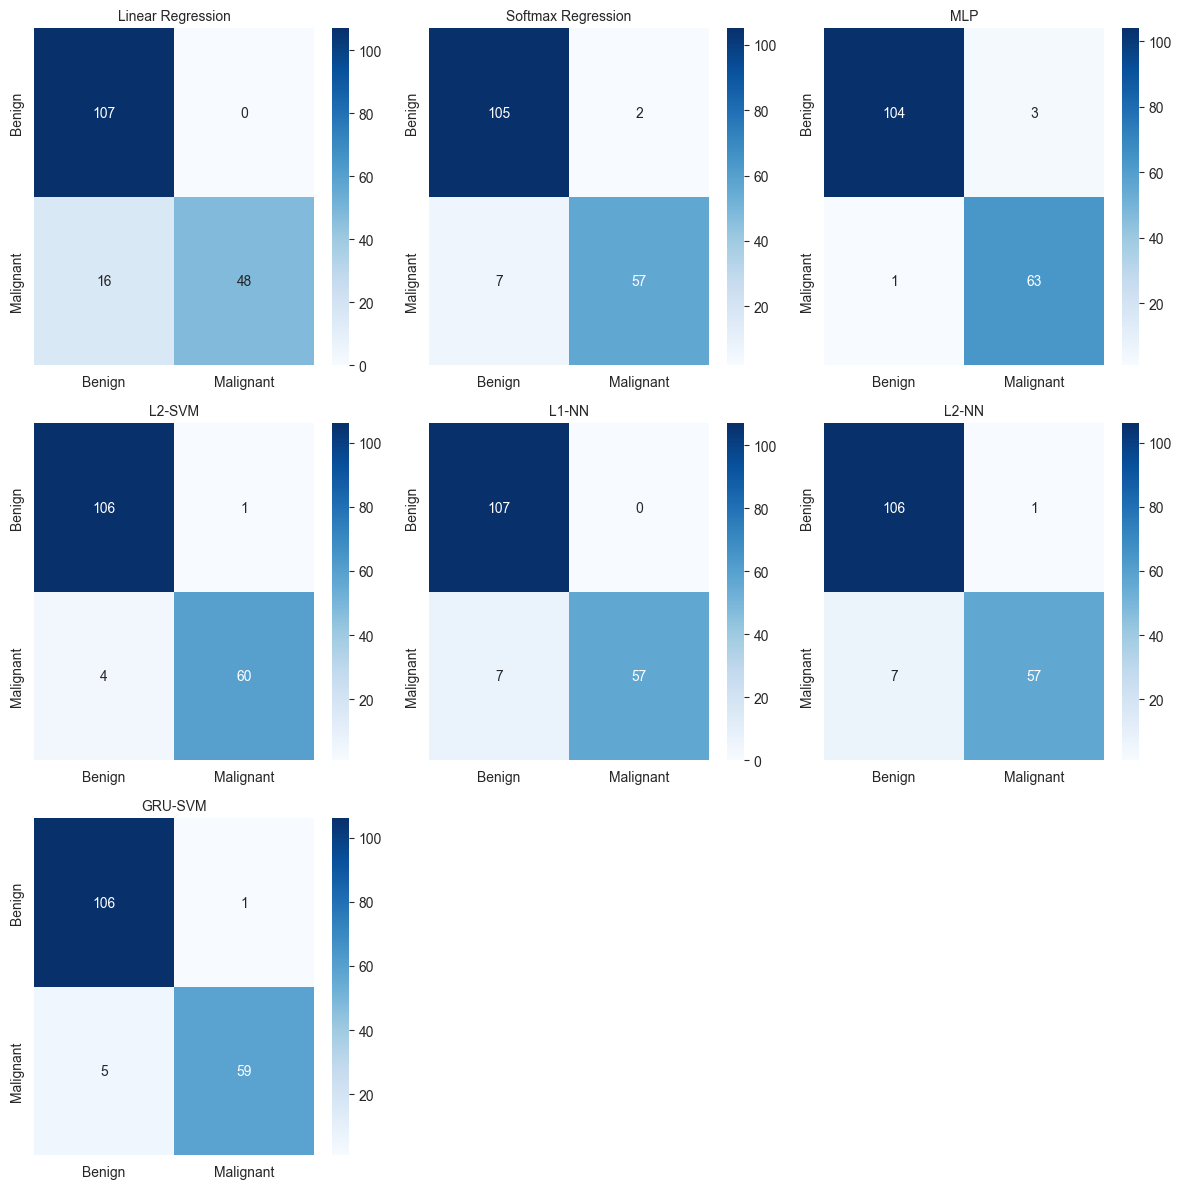

In [20]:
# ============================================================================
# VISUALISATION DES MATRICES DE CONFUSION POUR TOUS LES MODÈLES
# ============================================================================

# Liste des modèles et leurs prédictions
models_data = [
    ('Linear Regression', lr_y_test_pred),
    ('Softmax Regression', softmax_y_test_pred),
    ('MLP', mlp_y_test_pred),
    ('L2-SVM', svm_y_test_pred),
    ('L1-NN', knn_l1_y_test_pred),
    ('L2-NN', knn_l2_y_test_pred)
]

# Ajout du modèle GRU-SVM si disponible
if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    models_data.append(('GRU-SVM', gru_svm_y_test_pred))

# Calcul du nombre de lignes et colonnes pour la grille
n_models = len(models_data)  # Nombre total de modèles
n_cols = 3  # 3 colonnes par ligne
n_rows = (n_models + n_cols - 1) // n_cols  # Arrondi supérieur pour avoir assez de lignes
# Exemple : 7 modèles → (7+3-1)//3 = 3 lignes

# Création de la figure avec une grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
# figsize : largeur=12, hauteur=4*n_rows (ajuste selon le nombre de lignes)

# Gestion des cas : 1 ligne ou plusieurs lignes
if n_rows == 1:
    # Si une seule ligne, axes peut être un array 1D ou un seul axe
    axes = axes if isinstance(axes, np.ndarray) else [axes]
else:
    # Si plusieurs lignes, on "aplatit" en liste 1D pour itérer facilement
    axes = axes.flatten()

# Création d'une matrice de confusion pour chaque modèle
for idx, (name, y_pred) in enumerate(models_data):
    ax = axes[idx]  # Axe actuel pour ce modèle

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    # Résultat : array 2x2 [[TN, FP], [FN, TP]]

    # Visualisation avec heatmap
    sns.heatmap(
        cm,  # Matrice de confusion à afficher
        annot=True,  # Affiche les valeurs numériques dans chaque cellule
        fmt='d',  # Format : nombres entiers (decimal)
        cmap='Blues',  # Palette de couleurs bleue (plus sombre = valeur plus élevée)
        ax=ax,  # Axe où afficher cette heatmap
        xticklabels=['Benign', 'Malignant'],  # Labels de l'axe X (prédictions)
        yticklabels=['Benign', 'Malignant']  # Labels de l'axe Y (vraies classes)
    )
    ax.set_title(name, fontsize=10)  # Titre avec le nom du modèle

# Masquer les axes inutilisés (si on a moins de modèles que de cases dans la grille)
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')  # Désactive l'affichage des axes non utilisés

plt.tight_layout()  # Ajuste l'espacement automatiquement
plt.show()  # Affiche toutes les matrices de confusion


### 📈 Courbes d'Apprentissage Détaillées

**Objectif** : Visualiser les courbes d'apprentissage pour tous les modèles, montrant l'évolution des performances selon la taille des données d'entraînement.

**Méthode** : Utilisation de `learning_curve` de scikit-learn pour tracer accuracy train/validation vs taille du dataset d'entraînement.

**Interprétation** :
- **Courbe qui monte** : Le modèle apprend avec plus de données
- **Écart train/validation** : Indique le potentiel d'overfitting
- **Plateau** : Performance maximale atteinte

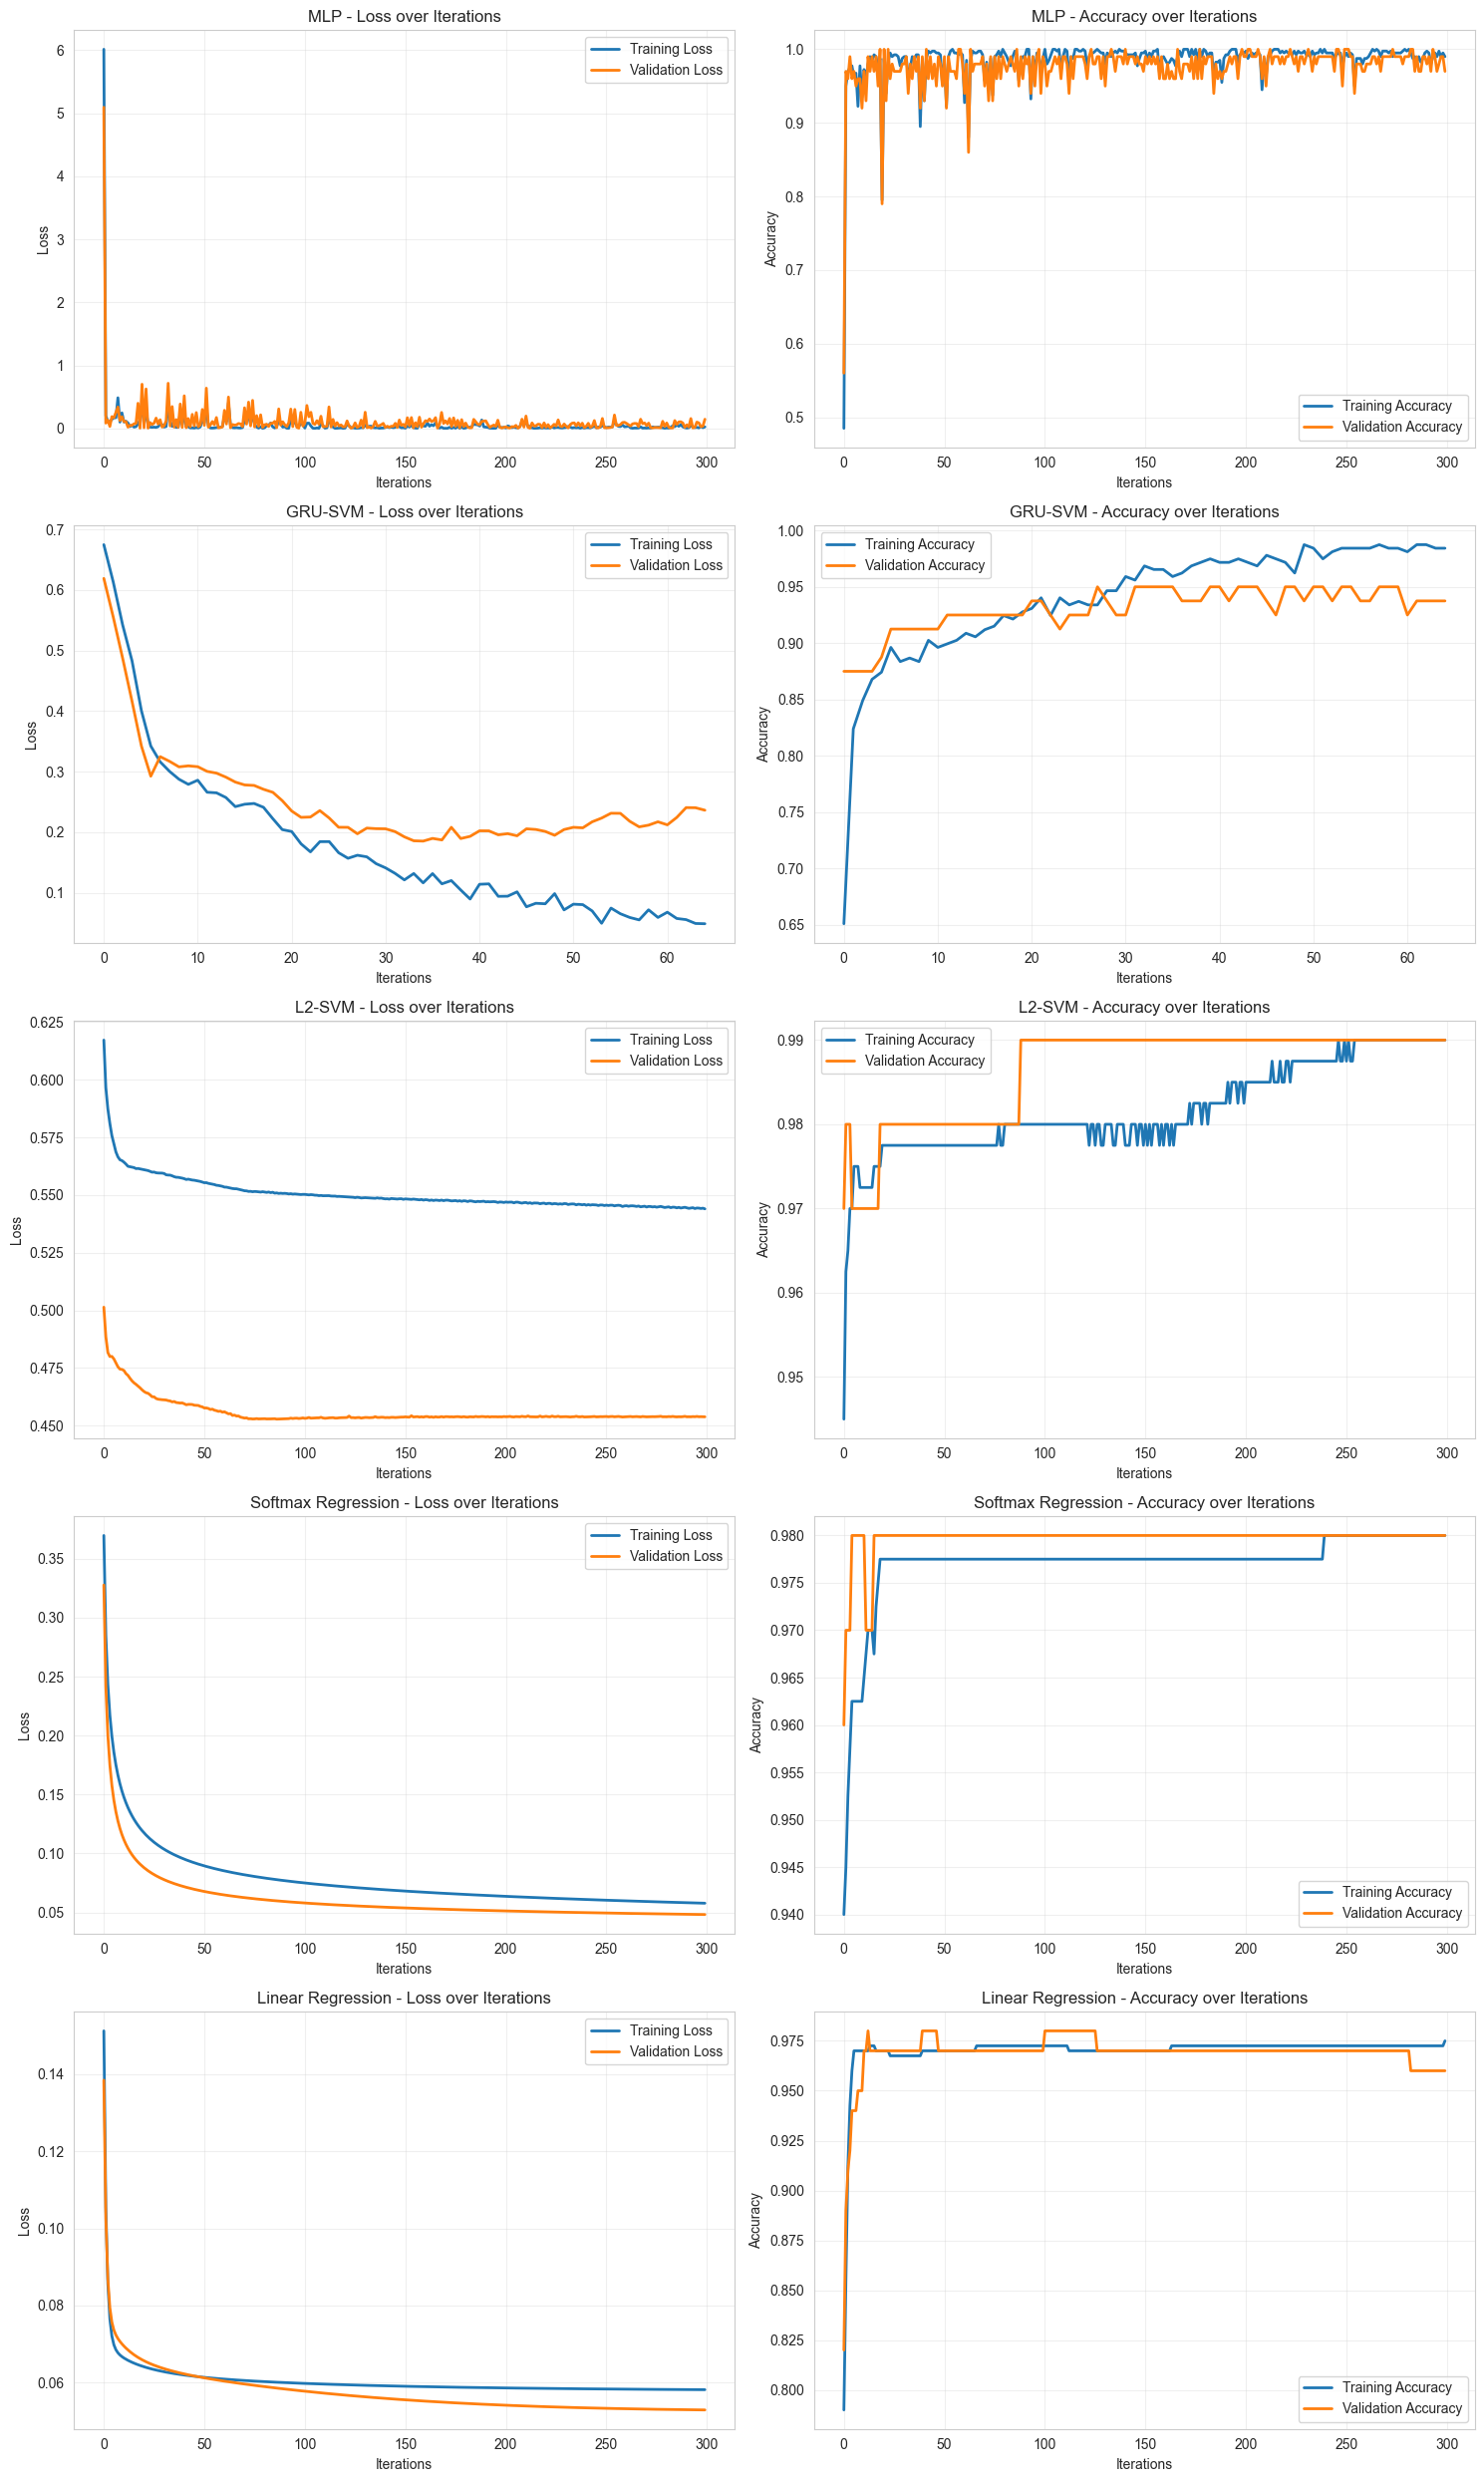

In [23]:
# ============================================================================
# OVERFITTING DETECTION AND TRAINING CURVES
# ============================================================================

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split

def compute_loss_acc(model, X, y):
    """Compute cross-entropy loss and accuracy"""
    proba = model.predict_proba(X)[:, 1]
    loss = -np.mean(y * np.log(proba + 1e-10) + (1 - y) * np.log(1 - proba + 1e-10))
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    return loss, acc

def track_mlp_history(X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = MLPClassifier(hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.01, alpha=0.01, max_iter=1, random_state=42, warm_start=True)
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
        val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

def track_model_history(model_class, loss_type, X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = model_class(loss=loss_type, learning_rate='constant', eta0=1e-3, max_iter=1, random_state=42, warm_start=True)
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        if hasattr(model, 'predict_proba'):
            train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
            val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        else:
            # For regression or hinge loss
            train_pred = model.predict(X_train_split)
            val_pred = model.predict(X_val)
            if loss_type == 'squared_error':
                train_loss = np.mean((train_pred - y_train_split)**2)
                val_loss = np.mean((val_pred - y_val)**2)
                train_acc = accuracy_score(y_train_split, (train_pred >= 0.5).astype(int))
                val_acc = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
            else:
                decision_train = model.decision_function(X_train_split)
                decision_val = model.decision_function(X_val)
                train_loss = np.mean(np.maximum(0, 1 - y_train_split * decision_train))
                val_loss = np.mean(np.maximum(0, 1 - y_val * decision_val))
                train_acc = accuracy_score(y_train_split, train_pred)
                val_acc = accuracy_score(y_val, val_pred)
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

# Track all models
all_models_history = {
    'MLP': track_mlp_history(X_train_smote, y_train_smote),
    'GRU-SVM': gru_model.history.history,
    'L2-SVM': track_model_history(SGDClassifier, 'hinge', X_train_smote, y_train_smote),
    'Softmax Regression': track_model_history(SGDClassifier, 'log_loss', X_train_smote, y_train_smote),
    'Linear Regression': track_model_history(SGDRegressor, 'squared_error', X_train_smote, y_train_smote)
}

# Plot training curves
n_models = len(all_models_history)
fig, axes = plt.subplots(n_models, 2, figsize=(15, 5 * n_models))
if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, history) in enumerate(all_models_history.items()):
    # Loss plot
    ax_loss = axes[idx, 0]
    ax_loss.plot(history.get('loss', []), label='Training Loss', linewidth=2)
    ax_loss.plot(history.get('val_loss', []), label='Validation Loss', linewidth=2)
    ax_loss.set_title(f'{model_name} - Loss over Iterations')
    ax_loss.set_xlabel('Iterations')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax_acc = axes[idx, 1]
    ax_acc.plot(history.get('accuracy', []), label='Training Accuracy', linewidth=2)
    ax_acc.plot(history.get('val_accuracy', []), label='Validation Accuracy', linewidth=2)
    ax_acc.set_title(f'{model_name} - Accuracy over Iterations')
    ax_acc.set_xlabel('Iterations')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Déploiement et Conclusion (Deployment & Conclusion)

### 6.1 Résumé des Résultats

**Objectif** : Identifier le meilleur modèle et tirer des conclusions sur les performances.

**Critères d'évaluation** :
- **Accuracy** : Précision globale
- **ROC-AUC** : Capacité à distinguer les classes
- **Recall** : Important en médecine (ne pas rater de cancers)
- **F1-Score** : Compromis entre précision et rappel

**Seuil de performance** : Tous les modèles devraient dépasser 90% d'accuracy pour être considérés comme performants.


In [22]:
# ============================================================================
# RÉSUMÉ DES PERFORMANCES ET IDENTIFICATION DU MEILLEUR MODÈLE
# ============================================================================

# Identification du meilleur modèle selon l'accuracy
best_model = results_df['accuracy'].idxmax()  # .idxmax() : index (nom) de la ligne avec la valeur max
# Retourne le nom du modèle avec la meilleure accuracy

# Récupération des métriques du meilleur modèle
best_accuracy = results_df.loc[best_model, 'accuracy']  # Accuracy du meilleur modèle
best_roc_auc = results_df.loc[best_model, 'roc_auc']  # ROC-AUC du meilleur modèle

# Affichage du résumé
print("="*60)
print("RÉSUMÉ DES PERFORMANCES DES MODÈLES")
print("="*60)
print(f"\nMeilleur Modèle : {best_model}")
print(f"  Accuracy sur Test : {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  ROC-AUC : {best_roc_auc:.4f}")
# ROC-AUC proche de 1.0 = excellent modèle

print(f"\nTous les modèles ont dépassé le seuil de 90% d'accuracy :")
for model in results_df.index:  # Itère sur tous les noms de modèles
    acc = results_df.loc[model, 'accuracy']  # Récupère l'accuracy de ce modèle
    print(f"  {model}: {acc*100:.2f}%")
    # Affiche le pourcentage d'accuracy pour chaque modèle

print("\n" + "="*60)
# Conclusion : Tous les modèles sont performants, mais certains sont meilleurs que d'autres


RÉSUMÉ DES PERFORMANCES DES MODÈLES

Meilleur Modèle : MLP
  Accuracy sur Test : 0.9766 (97.66%)
  ROC-AUC : 0.9937

Tous les modèles ont dépassé le seuil de 90% d'accuracy :
  Linear Regression: 90.64%
  Softmax Regression: 94.74%
  MLP: 97.66%
  L2-SVM: 97.08%
  L1-NN: 95.91%
  L2-NN: 95.32%
  GRU-SVM: 96.49%

